In [0]:
import pandas as pd
import numpy as np
import ast
import csv
import time
import random
import seaborn as sns

from operator import itemgetter
import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
users=np.zeros((40000,1))

In [0]:
users.shape

(40000, 1)

In [0]:
user_friends={}
user_tags={}
max_friends=0
min_friends=200000
def hasMoreTags(s):
    return s[-1]!=']'

# Generate User: Tags dict

In [0]:
start=time.time()
with open('/content/drive/My Drive/data.csv', 'r') as infile:
    reader = csv.reader(infile)
    count=-1
    
    for row in reader:
        #print(row[:7])
        count += 1
        if count == 0:
            continue
        id=row[0]
        #print(count)
        users[count-1][0]=id
        screenName=row[1]
        
        many_tags=hasMoreTags(row[2])
        
        offset=0
        #print('{} originally'.format(row[2]))
        #print(row[3])
        if many_tags:
            this_tags=[]
            for j in range(20):
                this_tags.append(row[2+j].strip('[]').strip(''))
                if row[2+j][-1]==']':
                    break
            #print('{} many tags'.format(this_tags))
            user_tags[id]=this_tags
            offset=len(this_tags)-1
            #print(offset)
        else:
            user_tags[id]=row[2].strip('[]').strip('')
            
        #followersCount=row[4]
        #print(offset)
        friendsCount=int(row[5+offset])
        #print(row[5+offset])
        max_friends=max(max_friends,friendsCount)
        min_friends=min(min_friends,friendsCount)
        friends=row[9+offset:]
        friends[0]=friends[0].strip('[]')
        friends[-1]=friends[-1].strip('[]')
        friends=[i.replace('"', '') for i in friends]
        friends=[i.strip() for i in friends]
        user_friends[id]=friends
        #print("{} : {}".format(count, friends))
end=time.time()
print('{} seconds'.format(end-start))

20.717490911483765 seconds


In [0]:
print(max_friends)
print(min_friends)

238749
101


# Generate/Read all tags

In [0]:
import re
def remove_hashtag(raw_str):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",raw_str).split())

In [0]:
try:
  all_tags=pd.read_csv('/content/drive/My Drive/all_tags_saved.csv')
except:
  all_tags=set()

  for u in user_tags:
    tags=user_tags[u]

    if type(tags) == str:
      all_tags.add(remove_hashtag(tags))
    else:
      for tag in tags:
        all_tags.add(remove_hashtag(tag))

  pd.DataFrame(list(all_tags)).to_csv('/content/drive/My Drive/all_tags_saved.csv')

In [0]:
len(all_tags)

128

# Generate Tag: User dict

In [0]:
tag_users={}

In [0]:
for u in user_tags:
  tags=user_tags[u]
  if type(tags)==str:
    normalized_tag=remove_hashtag(tags)
    if normalized_tag in tag_users:
      cur_tags=tag_users[normalized_tag]
      cur_tags.append(u)
      tag_users[normalized_tag]=cur_tags
    else:
      cur_tags=[]
      cur_tags.append(u)
      tag_users[normalized_tag]=cur_tags
  else:
    for tag in tags:
      normalized_tag=remove_hashtag(tag)
      if normalized_tag in tag_users:
        cur_tags=tag_users[normalized_tag]
        cur_tags.append(u)
        tag_users[normalized_tag]=cur_tags
      else:
        cur_tags=[]
        cur_tags.append(u)
        tag_users[normalized_tag]=cur_tags

In [0]:
len(tag_users)

128

In [0]:
x=list(tag_users.keys())
y=[len(item) for item in tag_users.values()]

tag_nums=pd.DataFrame({'tags':x,'num':y})

# Sort by the num of each tag
sorted_tag_nums=tag_nums.sort_values(by=['num'], ascending=[0])

In [0]:
sorted_tag_nums[:10]

,tags,num
0,nationaldogday,30513
17,respecttylerjoseph,6054
2,gloryoutnow,600
8,backtohogwarts,310
1,narcos,269
76,steve rogers,211
31,louisweloveyou,142
24,bournemouth,130
69,bundesliga,122
27,harry potter,103


In [0]:
sorted_x=sorted_tag_nums['tags'][:5]
sorted_y=sorted_tag_nums['num'][:5]

In [0]:
list(sorted_x)

['nationaldogday',
 'respecttylerjoseph',
 'gloryoutnow',
 'backtohogwarts',
 'narcos']

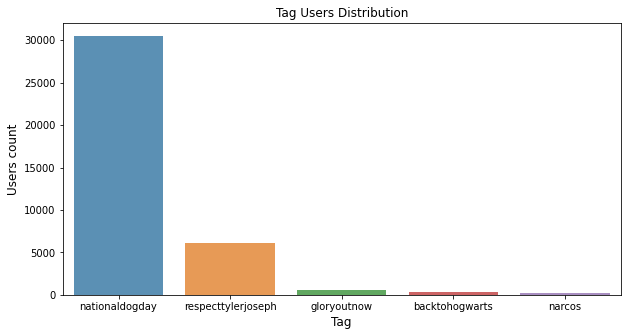

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(sorted_x, sorted_y, alpha=0.8)

plt.title('Tag Users Distribution')

plt.ylabel('Users count', fontsize=12)
plt.xlabel('Tag', fontsize=12)

plt.savefig('/content/drive/My Drive/network/tag_users.png')

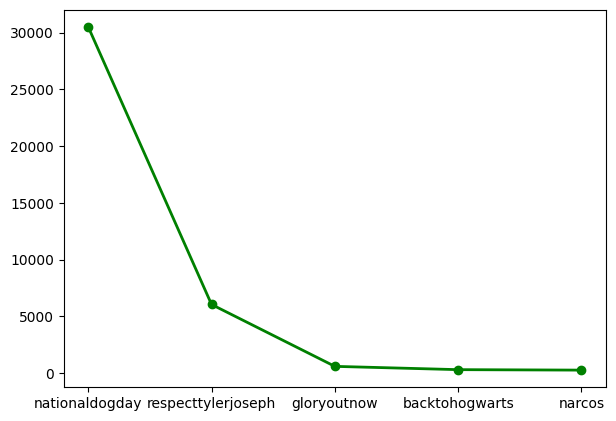

In [0]:
fig, axes = plt.subplots(figsize=(7,5), dpi=100)

plt.plot(sorted_x, sorted_y,'go-', label='line 1', linewidth=2)

In [0]:
# Generate the nodes and edges
nodes=user_friends.keys()
len(nodes)

40000

In [0]:
node_list=list(nodes)
with open('/content/drive/My Drive/nodelist.txt', 'w') as filehandle:
    for listitem in node_list:
        filehandle.write('%s\n' % listitem)

In [0]:
def calculate_shortest_dist(this_tag, k_nodes):
  count=1
  size_k=len(k_nodes)
  for index_a in range(size_k):

    no_paths=[]
    shortest_path_list=[]
    shortest_dist=[]

    for index_b in range(index_a+1, size_k):
      a=k_nodes[index_a]
      b=k_nodes[index_b]

      try:
        s_path=nx.shortest_path_length(G,a,b)
        shortest_path_list.append((a,b,s_path))
        shortest_dist.append(s_path)

      except:
        no_paths.append((a,b))

    with open('/content/drive/My Drive/network/200 users in top 5 tags/%s_shortest_path.txt'%this_tag,'a+') as fp:
        fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

    with open('/content/drive/My Drive/network/200 users in top 5 tags/%s_shortest_path.txt'%this_tag,'a+') as fp:
        fp.write('\n')

    with open('/content/drive/My Drive/network/200 users in top 5 tags/%s_no_path.txt'%this_tag,'a+') as fp:
        fp.write('\n'.join('%s %s'%x for x in no_paths))

    with open('/content/drive/My Drive/network/200 users in top 5 tags/%s_no_path.txt'%this_tag,'a+') as fp:
        fp.write('\n')
  
    with open('/content/drive/My Drive/network/200 users in top 5 tags/%s_shortest_dist.txt'%this_tag,'a+') as fp:
        fp.write('\n'.join('%s'%x for x in shortest_dist))

    with open('/content/drive/My Drive/network/200 users in top 5 tags/%s_shortest_dist.txt'%this_tag,'a+') as fp:
        fp.write('\n')

    #print('Finished {} node'.format(count))
    count+=1

# Calculate Six Degrees under the same tag

In [0]:
top_tags=list(sorted_x)

# Sample 200 user from top 5 tags to calculate 6 degree
k=200
try:

  f=open('/content/drive/My Drive/network/200 users in top 5 tags/%s_shortest_path.txt'%top_tags[0])

except IOError:
# Calculate
  for this_tag in top_tags:
    this_tag_users=set(tag_users[this_tag])
    this_tag_users_list=list(this_tag_users)
    k_nodes=set() #should not choose the same node twice

    while len(k_nodes)<k:
      n1=random.choice(this_tag_users_list)
      if n1 not in k_nodes:
        k_nodes.add(n1)
    #print(len(k_nodes))
    calculate_shortest_dist(this_tag,list(k_nodes))

# Analyze top 5 tags

In [0]:
try:
    
    f=open('/content/drive/My Drive/network/200 users in top 5 tags/%s_shortest_dist.txt'%top_tags[0])
    
except IOError: 
    for this_tag in top_tags:

      shortest_dist_list = pd.read_csv('/content/drive/My Drive/network/200 users in top 5 tags/%s_shortest_dist.txt'%this_tag, names=['dist'], sep=" ", header=None)

      shortest_dist_list['dist'].value_counts().to_csv('/content/drive/My Drive/network/200 users in top 5 tags/%s_info.txt'%this_tag,sep=':')
      shortest_dist_list.describe().to_csv('/content/drive/My Drive/network/200 users in top 5 tags/%s_info.txt'%this_tag, mode='a',sep=':')

# Visualize the results

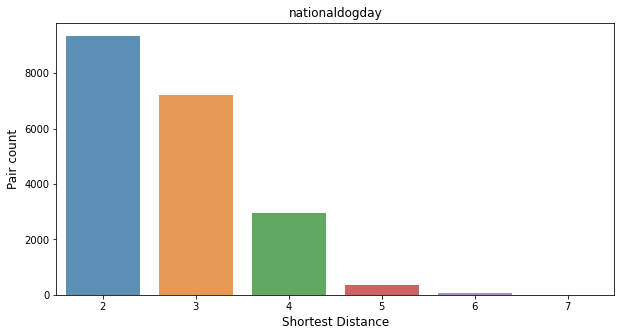

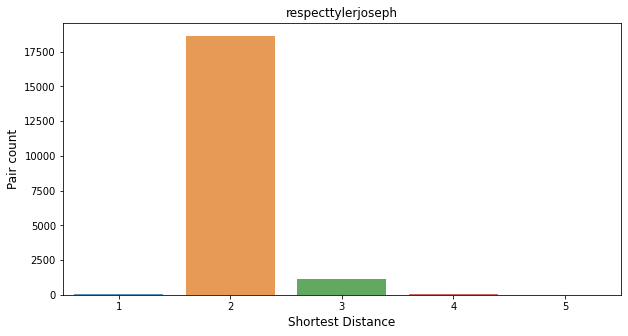

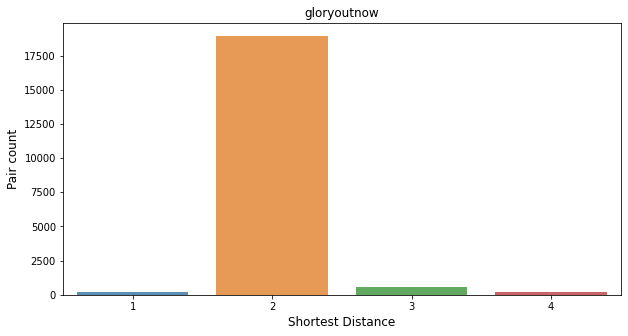

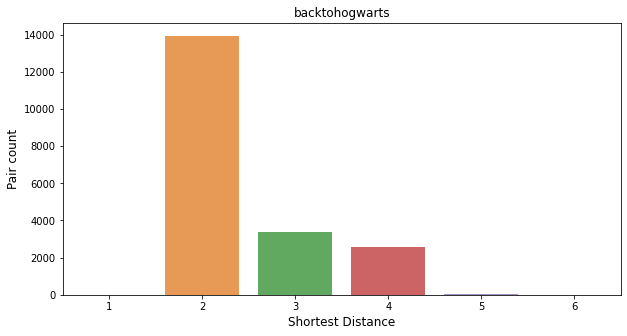

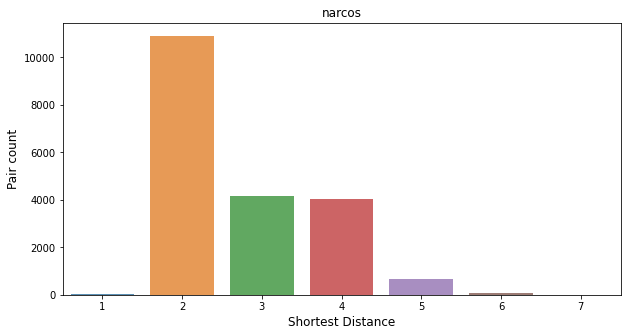

In [0]:
for this_tag in top_tags:
    shortest_dist_tag_list=pd.read_csv('/content/drive/My Drive/network/200 users in top 5 tags/%s_shortest_dist.txt'%this_tag,names=['dist'],sep=" ",header=None)

    sd_count=shortest_dist_tag_list['dist'].value_counts()
    
    plt.figure(figsize=(10,5))
    sns.barplot(sd_count.index, sd_count.values, alpha=0.8)

    plt.title('%s'%this_tag)
    plt.ylabel('Pair count', fontsize=12)
    plt.xlabel('Shortest Distance', fontsize=12)
    #plt.show()
    plt.savefig('/content/drive/My Drive/network/%s.png'%this_tag)

# Read the graph

In [0]:
begin=time.time()
try:
  # nx.write_gpickle(G,"test.gpickle")
  # Read from pickle
  G=nx.read_gpickle("/content/drive/My Drive/test.gpickle")
  end=time.time()
  print('Spent {} in reading graph'.format(end-begin))
except:
  G=nx.Graph()
  G.add_edges_from(edges)
  end=time.time()
  print('{} seconds'.format(end-start))

Spent 143.21823453903198 in reading graph


In [0]:
########### Print the summary of the graph ###########
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 12891798
Number of edges: 32842959
Average degree:   5.0952


# (Without Tags) Calculate the shortest path

In [0]:
#### Only Need to Calculate Once, more than 10 hours ####
#################### Select k nodes #####################
# node_list=[line.rstrip('\n') for line in open('/content/drive/My Drive/nodelist.txt')]

# k=5000
# k_nodes=set()

# while len(k_nodes)<k:
#   n1=random.choice(node_list)
#   if n1 not in k_nodes:
#       k_nodes.add(n1)

# print('Finished sampling {} nodes'.format(k))

# k_nodes=list(k_nodes)

# count=1
# pairs_count=0

# for index_a in range(k):
#   no_paths=[]
#   shortest_path_list=[]
#   shortest_dist=[]

#   for index_b in range(index_a+1,k):
#     pairs_count+=1
#     a=k_nodes[index_a]
#     b=k_nodes[index_b]

#     try:
#       s_path=nx.shortest_path_length(G,a,b)
#       shortest_path_list.append((a,b,s_path))
#       shortest_dist.append(s_path)

#     except:
#       no_paths.append((a,b))

#   with open('./data/real_%s_shortest_path.txt'%k,'a+') as fp:
#       fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

#   with open('./data/real_%s_no_path.txt'%k,'a+') as fp:
#       fp.write('\n'.join('%s %s'%x for x in no_paths))

#   with open('./data/real_%s_shortest_dist.txt'%k,'a+') as fp:
#       fp.write('\n'.join('%s'%x for x in shortest_dist))

#   print('Finished {} node'.format(count))
#   count+=1

# (Withou Tags) Analyze the data 5000 users

In [0]:
shortest_dist_list = pd.read_csv('/content/drive/My Drive/network/5000_shortest_dist.txt', names=['dist'], sep=" ", header=None)

In [17]:
shortest_dist_list['dist'].value_counts()

2    5980016
3    4624087
4    1835945
5      52419
6       2967
1       1823
7        238
8          5
Name: dist, dtype: int64

In [18]:
shortest_dist_list['dist'].count()

12497500

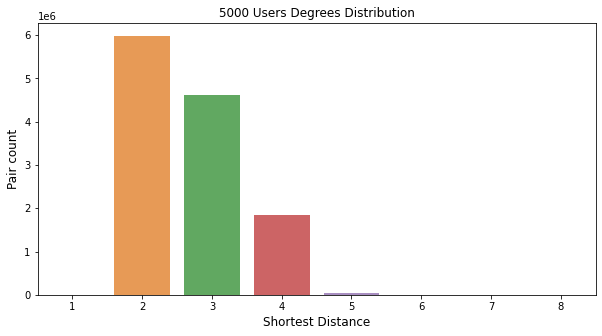

In [19]:
sd_count=shortest_dist_list['dist'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(sd_count.index, sd_count.values, alpha=0.8)

plt.title('5000 Users Degrees Distribution')
plt.ylabel('Pair count', fontsize=12)
plt.xlabel('Shortest Distance', fontsize=12)
plt.savefig('/content/drive/My Drive/network/5000_users.png')

In [0]:
degree_greater_than_6=sum(sd_count.loc[sd_count.index>6].values)
print("Pairs that have degree greater than 6 has {}".format(degree_greater_than_6))

Pairs that have degree greater than 6 has 243


In [0]:
degree_smaller_than_6=sum(sd_count.loc[sd_count.index<6].values)
print("Pairs that have degree smaller than 6 has {}".format(degree_smaller_than_6))

Pairs that have degree smaller than 6 has 12494290


In [0]:
degree_equal_to_6=sum(sd_count.loc[sd_count.index==6].values)
print("Pairs that have degree equal to 6 has {}".format(degree_equal_to_6))

Pairs that have degree equal to 6 has 2967


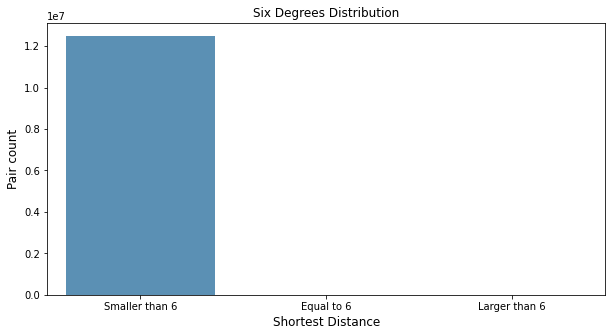

In [0]:
# Visualization
x_dist=['Smaller than 6', 'Equal to 6', 'Larger than 6']
y_count=[degree_smaller_than_6, degree_equal_to_6 ,degree_greater_than_6]

plt.figure(figsize=(10,5))

sns.barplot(x_dist, y_count, alpha=0.8)

plt.title('Six Degrees Distribution')

plt.ylabel('Pair count', fontsize=12)
plt.xlabel('Shortest Distance', fontsize=12)
plt.savefig('/content/drive/My Drive/network/six_degrees_distribution.png')

In [0]:
shortest_dist_list.describe()

,dist
count,1.249750e+07
mean,2.677295e+00
std,7.355787e-01
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,3.000000e+00
max,8.000000e+00


# (Withou Tags) Analyze the data 10000 users

In [0]:
shortest_dist_list = pd.read_csv('/content/drive/My Drive/network/10000_shortest_dist.txt', names=['dist'], sep=" ", header=None)

In [4]:
shortest_dist_list['dist'].value_counts()

2    24351527
3    18510936
4     6891586
5      216859
6       13818
1        9391
7         850
8          33
Name: dist, dtype: int64

In [5]:
shortest_dist_list['dist'].count()

49995000

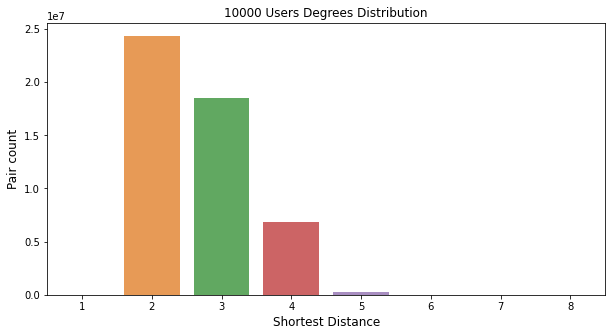

In [8]:
sd_count=shortest_dist_list['dist'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(sd_count.index, sd_count.values, alpha=0.8)

plt.title('10000 Users Degrees Distribution')
plt.ylabel('Pair count', fontsize=12)
plt.xlabel('Shortest Distance', fontsize=12)
plt.savefig('/content/drive/My Drive/network/10000_users.png')

In [9]:
degree_greater_than_6=sum(sd_count.loc[sd_count.index>6].values)
print("Pairs that have degree greater than 6 has {}".format(degree_greater_than_6))

Pairs that have degree greater than 6 has 883


In [10]:
degree_smaller_than_6=sum(sd_count.loc[sd_count.index<6].values)
print("Pairs that have degree smaller than 6 has {}".format(degree_smaller_than_6))

Pairs that have degree smaller than 6 has 49980299


In [11]:
degree_equal_to_6=sum(sd_count.loc[sd_count.index==6].values)
print("Pairs that have degree equal to 6 has {}".format(degree_equal_to_6))

Pairs that have degree equal to 6 has 13818


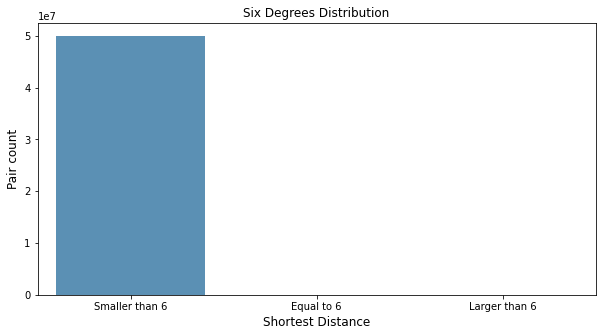

In [12]:
# Visualization
x_dist=['Smaller than 6', 'Equal to 6', 'Larger than 6']
y_count=[degree_smaller_than_6, degree_equal_to_6 ,degree_greater_than_6]

plt.figure(figsize=(10,5))

sns.barplot(x_dist, y_count, alpha=0.8)

plt.title('Six Degrees Distribution')

plt.ylabel('Pair count', fontsize=12)
plt.xlabel('Shortest Distance', fontsize=12)
plt.savefig('/content/drive/My Drive/network/six_degrees_distribution_10000.png')

In [13]:
shortest_dist_list.describe()

,dist
count,4.999500e+07
mean,2.659966e+00
std,7.281344e-01
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,3.000000e+00
max,8.000000e+00
